In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, confusion_matrix, roc_curve, auc, RocCurveDisplay

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pycm import ConfusionMatrix

In [2]:
# all data found on github repo
df_reviews = pd.read_csv('https://tinyurl.com/moviereviewsdata')

df_train, df_test = train_test_split(
    df_reviews, 
    test_size = 0.25, 
    random_state = 123
)

## Regression Metrics

In [3]:
# we'll use 'features' later also
features = [
    "review_year_0", 
    "release_year_0",
    "age_sc", 
    "length_minutes_sc", 
    "total_reviews_sc", 
    "word_count_sc", 
    "genre", 
    ]

model =  'rating ~ ' + " + ".join(features)

model_lr_train = smf.ols(formula = model, data = df_train).fit()

In [4]:
predictions = model_lr_train.predict(df_test)

### R2

In [5]:
residual_ss = np.sum((df_test.rating - predictions)**2)
total_ss = np.sum((df_test.rating - np.mean(df_test.rating))**2)

1 - residual_ss / total_ss, r2_score(df_test.rating, predictions)

(0.508431158347433, 0.508431158347433)

In [6]:
# conceptually identical, but slight difference due to
# how calculations are done (not shown)
# np.corrcoef(df_test.rating, predictions)[0, 1]**2

### RMSE

In [7]:
mse = np.mean((df_test.rating - predictions)**2)
mse

mean_squared_error(df_test.rating, predictions)

np.sqrt(mse)

mean_squared_error(df_test.rating, predictions, squared = False)

/Users/micl/anaconda3/envs/book-of-models/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.4560513738102493

### MAE

In [8]:
np.mean(abs(df_test.rating - predictions))

mean_absolute_error(df_test.rating, predictions)

0.3704072983307527

### MAPE

In [9]:
np.mean(
    abs(df_test.rating - predictions) / 
    df_test.rating
) * 100

mean_absolute_percentage_error(df_test.rating, predictions) * 100

13.464399850975898

## Classification Metrics

In [10]:
model =  'rating_good ~ ' + " + ".join(features)

model_class_train = smf.glm(
    formula = model,
    data = df_train,
    family = sm.families.Binomial()
).fit()


model_class_train.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            rating_good   No. Observations:                  750
Model:                            GLM   Df Residuals:                      736
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -367.76
Date:                Mon, 29 Jul 2024   Deviance:                       735.52
Time:                        20:51:12   Pearson chi2:                     672.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3189
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.7239      0.439     -3.931      0.000      -2.583      -0.864
genre[T.Comedy]       2.4492      0.448      5.462      0.000       1.570       3.328
genre[T.Drama]        1.9952      0.256      7.789      0.000       1.493       2.497
genre[T.Horror]      -0.0215      0.397     -0.054      0.957      -0.799       0.756
genre[T.Kids]        -0.1908      0.358     -0.533      0.594      -0.893       0.511
genre[T.Other]        0.0147      0.363      0.041      0.968      -0.696       0.726
genre[T.Romance]      0.1751      0.385      0.455      0.649      -0.579       0.929
genre[T.Sci-Fi]       0.2399      0.416      0.577      0.564      -0.575       1.055
review_year_0         0.0272      0.018      1.529      0.126      -0.008       0.062
release_year_0        0.0355      0.011      3.370      0.001       0.015       0.056
age_sc               -0.2167      0.094     -2.296      0.022      -0.402      -0.032
length_minutes_sc     0.5661      0.106      5.360      0.000       0.359       0.773
total_reviews_sc      0.9022      0.109      8.312      0.000       0.689       1.115
word_count_sc        -0.5834      0.106     -5.522      0.000      -0.790      -0.376
=====================================================================================
"""

In [11]:
predicted_prob = model_class_train.predict(df_test)

predicted_class = np.where(predicted_prob >= .5, 1, 0)

predicted_class = pd.Series(predicted_class)

In [12]:
rating_cm = confusion_matrix(df_test.rating_good, predicted_class)

### Accuracy and More

In [13]:
confusion_matrix = pd.crosstab(
    predicted_class,
    df_test.rating_good.reset_index(drop=True), 
).to_numpy()

TN = confusion_matrix[0, 0]
TP = confusion_matrix[1, 1]
FN = confusion_matrix[0, 1]
FP = confusion_matrix[1, 0]

acc = (TP + TN) / np.sum(confusion_matrix)  # accuracy
tpr = TP / (TP + FN)  # sensitivity, true positive rate, recall
tnr = TN / (TN + FP)  # specificity, true negative rate
ppv = TP / (TP + FP)  # precision, positive predictive value
npv = TN / (TN + FN)  # negative predictive value

In [14]:
cm = ConfusionMatrix(
    df_test.rating_good.to_numpy(), 
    predicted_class.to_numpy(), 
    digit = 3
)

# print(cm) # lots of stats!

package_result = [
    cm.class_stat[stat][1] # get results specific to class 1
    for stat in  ['ACC', 'TPR', 'TNR', 'PPV', 'NPV']
]

pd.DataFrame({
    'metric':['ACC', 'TPR', 'TNR', 'PPV', 'NPV'],
    'ours': [acc, tpr, tnr, ppv, npv],
    'package': package_result
})

,metric,ours,package
0,ACC,0.796000,0.796000
1,TPR,0.857143,0.857143
2,TNR,0.726496,0.726496
3,PPV,0.780822,0.780822
4,NPV,0.817308,0.817308


### ROC/Ideal Decision Point

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.8715378189062399

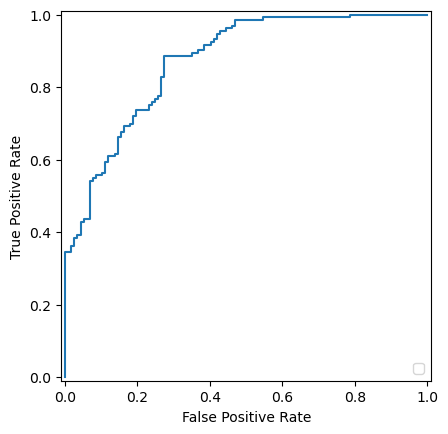

In [15]:
fpr, tpr, thresholds = roc_curve(
    df_test.rating_good, 
    predicted_prob
)

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

auc(fpr, tpr)

In [16]:
cut = thresholds[np.argmax(tpr - fpr)]

pd.DataFrame({
    'threshold': [cut],
    'TNR': [1 - fpr[np.argmax(tpr - fpr)]],
    'TPR': [tpr[np.argmax(tpr - fpr)]]
})

,threshold,TNR,TPR
0,0.483032,0.726496,0.887218


## Model Selection and Comparison

In [17]:

model_lr_3feat = smf.ols(
    formula='rating ~ review_year_0 + release_year_0 + age_sc',
    data=df_train
).fit()

model_lr_interact = smf.ols(
    formula='rating ~ review_year_0 * genre + release_year_0 * genre + age_sc * genre',
    data=df_train
).fit()

model_lr_train = smf.ols(
    formula=
    '''
    rating ~ 
    review_year_0
    + release_year_0
    + age_sc
    + length_minutes_sc
    + total_reviews_sc
    + word_count_sc
    + genre
    ''' 
    ,
    data=df_train
).fit()

models = [model_lr_3feat, model_lr_train, model_lr_interact]

In [18]:

# get the predictions, calculate RMSE
result = pd.DataFrame({
    'model': ["3 features", "original", "3 feat+interact"],
    'rmse': [
        root_mean_squared_error(
            df_test.rating, 
            model.predict(df_test[features])
        )
        for model in models
    ]
})

result.sort_values('rmse')

,model,rmse
1,original,0.456051
2,3 feat+interact,0.561521
0,3 features,0.638868


In [19]:
# !pip install arviz

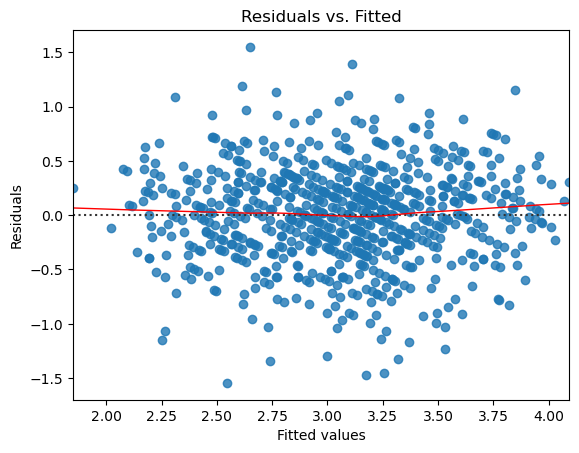

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.residplot(
    x = model_lr_train.fittedvalues, 
    y = df_train.rating, 
    lowess = True, 
    line_kws={'color': 'red', 'lw': 1}
)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.show()




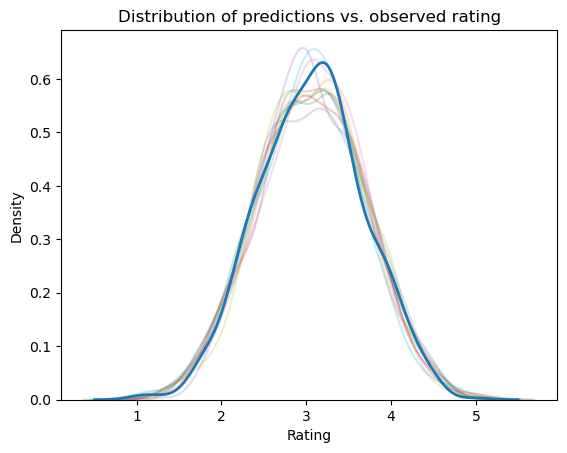

In [21]:
# get the model parameters
pp = model_lr_train.model.get_distribution(
    params = model_lr_train.params, 
    scale  = model_lr_train.scale, 
    exog   = model_lr_train.model.exog
)

# Generate 10 simulated predictive distributions
pp_samples = [pp.rvs() for _ in range(10)]

# Plot the distribution of pp_samples
for sample in pp_samples:
    sns.kdeplot(sample, label='pp.rvs()', alpha=0.25)

# Overlay the density plot of df_train.rating
sns.kdeplot(
    df_train.rating.to_numpy(), 
    label='df_train.rating', 
    linewidth=2
)

plt.xlabel('Rating')
plt.ylabel('Density')
plt.title('Distribution of predictions vs. observed rating')
plt.show()

## Understanding The Features

### Average marginal effects

In [22]:
fudge_factor = 1e-3

fudge_plus = model_class_train.predict(
    df_train.assign(
        word_count_sc = df_train.word_count_sc + fudge_factor/2
    )
)

fudge_minus = model_class_train.predict(
    df_train.assign(
        word_count_sc = df_train.word_count_sc - fudge_factor/2
    )
)

marginal_effect = np.mean(fudge_plus - fudge_minus) / fudge_factor

marginal_effect

-0.09447284318194568

### Marginal means

In [23]:
marginal_means = pd.DataFrame({
    "genre": df_train.genre.unique(),
    "avg_pred": [
        model_lr_train.predict(
            df_train.assign(genre = g)
        ).mean()
        for g in df_train.genre.unique()
    ]
})

marginal_means

,genre,avg_pred
0,Romance,2.864043
1,Other,2.847952
2,Sci-Fi,2.823101
3,Drama,3.405924
4,Horror,2.847344
5,Action/Adventure,2.840424
6,Kids,2.803119
7,Comedy,3.360565


### Counterfactual Predictions

In [24]:
df_happiness_2018 = pd.read_csv('https://tinyurl.com/527pbc4v')

model_happiness = smf.ols(
    formula = 'happiness_score ~ \
        log_gdp_per_capita \
        + healthy_life_expectancy_at_birth \
        + generosity \
        + freedom_to_make_life_choices \
        + confidence_in_national_government',
    data = df_happiness_2018
).fit()

df_us_russia = df_happiness_2018[
        df_happiness_2018.country.isin(['United States', 'Russia'])
    ]

happiness_gdp_freedom_values = df_happiness_2018.loc[
    df_happiness_2018.country.isin(['United States', 'Russia']),
    ['log_gdp_per_capita', 'freedom_to_make_life_choices']
]

base_predictions = model_happiness.predict(df_us_russia)

# switch up their GDP and freedom!
df_switch = df_us_russia.copy()

df_switch[['log_gdp_per_capita', 'freedom_to_make_life_choices']] = (
    df_switch[['log_gdp_per_capita', 'freedom_to_make_life_choices']].values[::-1]
)    

switch_predictions = model_happiness.predict(df_switch)

pd.DataFrame({
    'country': ['Russia', 'USA'],
    'base_predictions': base_predictions,
    'switch_predictions': switch_predictions,
    'diff_in_happiness': switch_predictions - base_predictions
}).round(3)

,country,base_predictions,switch_predictions,diff_in_happiness
85,Russia,5.676,6.374,0.698
106,USA,6.798,6.100,-0.698


### SHAP Values

Redo previous model using raw scale data.

In [25]:
model_lr_3feat = smf.ols(
    formula = 'rating ~ \
    age \
    + release_year \
    + length_minutes',
    data = df_reviews
).fit()

In [28]:
# first we need to get the average prediction
avg_pred = model_lr_3feat.predict(df_reviews).mean()

# observation of interest we want shap values for
obs_of_interest = pd.DataFrame({
    'age': 30,
    'release_year': 2020,
    'length_minutes': 110
}, index = ['new_observation'])

# then we need to get the prediction for the feature value of interest
# for all observations, and average them
pred_age_30 = model_lr_3feat.predict(
    df_reviews.assign(
        age = obs_of_interest.loc['new_observation', 'age']
    )
)

pred_year_2022 = model_lr_3feat.predict(
    df_reviews.assign(
        release_year = obs_of_interest.loc['new_observation', 'release_year']
    )
)

pred_length_110 = model_lr_3feat.predict(
    df_reviews.assign(
        length_minutes = obs_of_interest.loc['new_observation', 'length_minutes']
    )
)

# then we can calculate the shap values
shap_value_ours = pd.DataFrame({
    'age': pred_age_30.mean() - avg_pred,
    'release_year': pred_year_2022.mean() - avg_pred,
    'length_minutes': pred_length_110.mean() - avg_pred
}, index = ['new_observation'])


In [30]:

# now use the shap package for this; it does not work with statsmodels though,
# and single feature models are a bit cumbersome, 
# but we still get there in the end!
import shap
from sklearn.linear_model import LinearRegression

# set data up for shap and sklearn
fnames = [
    'age', 
    'release_year', 
    'length_minutes'
]

X = df_reviews[fnames]
y = df_reviews['rating']

# use a linear model that works with shap
model_reviews = LinearRegression().fit(X, y)

# 1000 instances for use as the 'background distribution'
X_sample = shap.maskers.Independent(data = X, max_samples = 1000)  

# # compute the SHAP values for the linear model
explainer = shap.Explainer(
    model_reviews.predict, 
    X_sample   
)

shap_values = explainer(obs_of_interest)

shap_value_package = pd.DataFrame(
    shap_values.values[0, :], 
    index = fnames, 
    columns = ['new_observation']
).T

pd.concat([shap_value_ours, shap_value_package]).round(3)

,age,release_year,length_minutes
new_observation,0.063,0.206,-0.141
new_observation,0.063,0.206,-0.141


### Global assessment of feature importance

In [27]:
model_importance = smf.ols(
    formula = 'rating ~ \
        word_count \
        + age \
        + review_year \
        + release_year \
        + length_minutes \
        + children_in_home \
        + total_reviews',
    data = df_reviews
).fit()